우선 bmp 이미지를 run-length encoding으로 압축. 

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import os, sys

In [10]:

def run_length_encode(binary_data: np.ndarray) -> list:
    """
    Run-Length Encoding for 1-bit data
    """
    if len(binary_data) == 0:
        return []

    encoded = []
    current_value = binary_data[0]
    count = 1

    for val in binary_data[1:]:
        if val == current_value and count < 255:
            count += 1
        else:
            encoded.extend([count, current_value])
            current_value = val
            count = 1
    encoded.extend([count, current_value])
    return encoded

def bits_to_bytes(bits: str) -> list[int]:
    """Convert a string of bits to a list of bytes."""
    a = [int(bits[i:i+8], 2) for i in range(0, len(bits), 8)]
    a.reverse()
    return a

def number_to_bits(a: int, bitlen: int=8) -> str:
    """Convert a number to a binary string of specified bit length."""
    return format(a, '0{}b'.format(bitlen))

In [11]:
image_path = os.path.join("/home/jhchang/dlpyc900/LCR500YX_Images/0001.bmp")

In [12]:
img = Image.open(image_path)
img_array = np.array(img, dtype= np.uint8)
# img_array = (img_array > 0).astype(np.uint8)

mid_x = img_array.shape[1] // 2
left_half = img_array[:, :mid_x]
right_half = img_array[:, mid_x:]

type :  <class 'numpy.ndarray'> <class 'numpy.uint8'> |  size :  (1200, 1024)


(-0.5, 1023.5, 1199.5, -0.5)

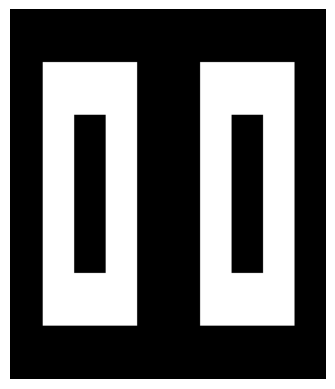

In [13]:
print('type : ' , type(left_half), type(left_half[0][0]) ,'|  size : ',  np.shape(left_half))
plt.imshow(left_half, cmap= 'gray')
plt.axis('off')

In [26]:
def rgb24(img_bin: np.ndarray) -> np.ndarray:
    """
    1비트 2D numpy array (0,1) → 24비트 3채널 RGB numpy array (uint8)
    """
    assert img_bin.dtype == np.uint8, "Input must be uint8."
    assert img_bin.ndim == 2, "Input must be 2D array."

    height, width = img_bin.shape
    img_rgb = np.zeros((height, width, 3), dtype=np.uint8)
    img_rgb[img_bin == 1] = [255, 255, 255]  # 흰색

    return img_rgb

def rgb24_to_bytes(img_rgb: np.ndarray) -> bytes:
    """
    24비트 3채널 RGB numpy array (H, W, 3) → 1D byte array
    """
    assert img_rgb.dtype == np.uint8, "Input must be uint8."
    assert img_rgb.ndim == 3 and img_rgb.shape[2] == 3, "Input must be 3-channel RGB."

    return img_rgb.tobytes()

def RLE(img):
    """
    Run Length Enocding 실행 함수(이미지 분할은 다른 함수로 실행)
    dlp에 입력되는 이미지는 24비트 RGB 이미지 파일이다. 따라서 gray scale image에서도 RGB에 대한 각각의 값(8비트)를 인코딩 해주어야함. 
    이 함수는 gray scale를 대상으로 변환하므로 R=G=B인 24비트 이미지로 인코딩을 해야한다. 
    input : numpy-uint8 이미지 array(2D) 파일
    return : compressed 1d numpy image array  
    """

def rle_encode_dlp(image: np.ndarray) -> bytearray:
    """
    DLPC900 규격에 맞춘 RLE 인코딩 함수.
    Input : uint8 numpy array, shape (height, width, 3)
    Output: bytearray
    """

    assert image.ndim == 3 and image.shape[2] == 3, "입력은 (H, W, 3) 형태여야 합니다."

    height, width, _ = image.shape
    encoded = bytearray()

    for y in range(height):
        x = 0
        while x < width:
            # 현재 픽셀
            current_pixel = image[y, x]

            # 반복되는지 확인
            run_length = 1
            while (x + run_length < width) and np.array_equal(image[y, x + run_length], current_pixel) and run_length < 255:
                run_length += 1

            if run_length > 1:
                # 반복 패턴
                encoded.append(run_length)
                encoded += current_pixel.tobytes()
                x += run_length
            else:
                # 비반복(Uncompressed) 구간 찾기
                start_x = x
                x += 1
                while (x < width) and not np.array_equal(image[y, x], image[y, x-1]) and (x - start_x) < 255:
                    x += 1
                uncompressed_length = x - start_x

                encoded.append(0)
                encoded.append(uncompressed_length)
                for i in range(start_x, start_x + uncompressed_length):
                    encoded += image[y, i].tobytes()

        # End-of-Line 삽입
        encoded.append(0x00)
        encoded.append(0x00)

    # 마지막에 End-of-Image 삽입
    encoded.append(0x00)
    encoded.append(0x01)

    return encoded

In [34]:
def rle_decode_dlp(encoded: bytes, width: int, height: int) -> np.ndarray:
    decoded = np.zeros((height, width, 3), dtype=np.uint8)
    offset = 0
    x, y = 0, 0

    while offset < len(encoded):
        if y >= height:
            break
        b = encoded[offset]
        offset += 1
        if b == 0:  # raw pixels
            c = encoded[offset]
            offset += 1
            for _ in range(c):
                if y >= height:
                    break
                pixel = encoded[offset:offset+3]
                decoded[y, x] = np.frombuffer(pixel, dtype=np.uint8)
                offset += 3
                x += 1
                if x >= width:
                    x = 0
                    y += 1
        else:  # run-length
            n = b
            pixel = encoded[offset:offset+3]
            offset += 3
            for _ in range(n):
                if y >= height:
                    break
                decoded[y, x] = np.frombuffer(pixel, dtype=np.uint8)
                x += 1
                if x >= width:
                    x = 0
                    y += 1

    return decoded


In [20]:
a = np.array([[1, 0] ,[0,1]], dtype=np.uint8)

img_rgb  = rgb24(a)
print(np.shape(img_rgb))
img_rgb = img_rgb.tobytes()
print(img_rgb, list(img_rgb))

(2, 2, 3)
b'\xff\xff\xff\x00\x00\x00\x00\x00\x00\xff\xff\xff' [255, 255, 255, 0, 0, 0, 0, 0, 0, 255, 255, 255]


압축 전: 3686400 bytes
압축 후: 37346 bytes
복원 성공 여부: True


(-0.5, 1023.5, 1199.5, -0.5)

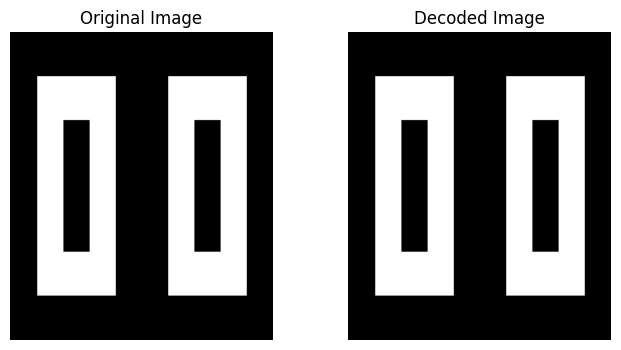

In [35]:
img = rgb24(left_half)
encoded = rle_encode_dlp(img)
print(f"압축 전: {img.nbytes} bytes")
print(f"압축 후: {len(encoded)} bytes")

height , width, _ = np.shape(img)
decoded = rle_decode_dlp(encoded, width, height)
print("복원 성공 여부:", np.array_equal(img, decoded))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(decoded)
axs[1].set_title("Decoded Image")
axs[1].axis('off')

In [42]:
encoded

bytearray(b'\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\xff\x00\x00\x00\x04\x00\x00\x00\x00\x00\xff\x00\x00\x00\xff

In [ ]:
[xff\xff\xff\xcc\x00\x00\x00\xff\xff\xff\xff3\xff\xff\xfff]

In [41]:
[0xfff]

[4095]

In [24]:
def bgr_to_gray(bgr_bytes):
    """BGR 3바이트를 uint32로 변환한 뒤 그레이스케일 추출"""
    b, g, r = bgr_bytes
    return (r << 16) | (g << 8) | b

def decode_erle(data: bytes, width=1024, height=1200):
    """
    ERLE로 압축된 이미지 데이터를 복원

    Parameters:
        data (bytes): ERLE 압축된 바이트 시퀀스
        width (int): 이미지 가로 해상도
        height (int): 이미지 세로 해상도

    Returns:
        np.ndarray: 복원된 uint32 이미지 (shape = [height, width])
    """
    # Skip 48-byte header
    offset = 48
    image = np.zeros((height, width), dtype=np.uint32)

    for row in range(height):
        col = 0
        while col < width:
            b0 = data[offset]
            offset += 1

            if b0 == 0x00:
                b1 = data[offset]
                offset += 1

                if b1 == 0x00:
                    # End of line
                    break
                elif b1 == 0x01:
                    # Copy from previous line
                    n, step = decode_length(data, offset)
                    offset += step
                    if row == 0:
                        raise ValueError("First row cannot copy from previous line")
                    image[row, col:col+n] = image[row-1, col:col+n]
                    col += n
                else:
                    # Raw pixels
                    n, step = decode_length(data, offset-1)  # include b1
                    offset += step - 1  # already used b1
                    for _ in range(n):
                        bgr = data[offset:offset+3]
                        pixel = bgr_to_gray(bgr)
                        image[row, col] = pixel
                        offset += 3
                        col += 1

            elif b0 & 0x80:  # Long run
                if offset >= len(data):
                    break
                b1 = data[offset]
                offset += 1
                run_length = ((b1 << 7) | (b0 & 0x7F))
                bgr = data[offset:offset+3]
                pixel = bgr_to_gray(bgr)
                offset += 3
                image[row, col:col+run_length] = pixel
                col += run_length

            else:
                # Short run
                run_length = b0
                bgr = data[offset:offset+3]
                pixel = bgr_to_gray(bgr)
                offset += 3
                image[row, col:col+run_length] = pixel
                col += run_length

    # Skip end-of-image marker (00 01 00)
    return image

def decode_length(data, offset):
    """decode ERLE variable-length integer"""
    b0 = data[offset]
    if b0 & 0x80:
        b1 = data[offset+1]
        value = ((b1 << 7) | (b0 & 0x7F))
        return value, 2
    else:
        return b0, 1



In [ ]:
decoded_img = decode_erle(compressed_img)
plt.imshow(decoded_img)

In [ ]:
(100 + 156-1)%256


In [ ]:
compressed_data = run_length_encode(left_half.flatten())

print(f"압축 전 크기: {len(left_half.flatten())} 비트")
print(f"압축 후 크기: {len(compressed_data)} 바이트")
print(compressed_data)

In [ ]:
print(len(compressed_data)+48)
a = number_to_bits(len(compressed_data)+48,bitlen = 32)[16:]
print(a)
# a = a[::-1]
print(a, len(a))
bits_to_bytes(a)

In [ ]:
import dlpyc900.dlp as dlpyc

num2bit = dlpyc.number_to_bits(len(compressed_data),bitlen = 32)
bit2byte = dlpyc.bits_to_bytes(num2bit)

print(num2bit, bit2byte)

In [ ]:
image_index =0
dlpyc.bits_to_bytes('0'*11 + dlpyc.number_to_bits(image_index,bitlen = 5))

In [ ]:
dlpyc.bits_to_bytes(dlpyc.number_to_bits(504,bitlen = 16))

In [ ]:
dlpyc.bits_to_bytes(dlpyc.number_to_bits(int(2048/2) ,bitlen = 16))

In [ ]:
a = np.zeros(200)
for i in range(0, len(a), 30):
    print(a[i:i+30])

In [ ]:
import dlpyc900.dlp as dlpyc
import usb.core
import pretty_errors
import time
from PIL import Image
import os, sys

# DLP 장치 찾기
dev = usb.core.find(idVendor=0x0451, idProduct=0xc900)
if dev is None:
    raise ValueError("DMD device not found")

interface = 0  # 보통 0번 인터페이스 사용

# 리눅스에서 커널 드라이버가 인터페이스를 점유하고 있다면 분리
if dev.is_kernel_driver_active(interface):
    print("커널 드라이버가 활성화되어 있어 분리 중...")
    dev.detach_kernel_driver(interface)
reset = True


# define class dlp
dlp=dlpyc.dmd()

# print status of DLP product(Optional)


# set OTF mode
dlp.set_display_mode('otf')
print(dlp.get_display_mode())
# Add a pattern to the Look Up Table & Start displaying patterns from the Look Up Table (LUT)
dlp.setup_pattern_LUT_definition(pattern_index = 3, exposuretime = 150000, color = 0, bitdepth = 1) # call this function as many times as the number of patterns you want to upload
# dlp.setup_pattern_LUT_definition(pattern_index = 1, exposuretime = 15000, color = 2, bitdepth = 1) # call this function as many times as the number of patterns you want to upload
dlp.start_pattern_from_LUT(nr_of_LUT_entries=1, nr_of_patterns_to_display= 0)

# option - trun on praimary & secondary controler
turn_on = 1

if turn_on == 1: 
    controller_status = dlp.send_command('w', 10, 0x0031, [3])

# processing bmp image
image_folder = "/home/jhchang/dlpyc900/LCR500YX_Images/"
filename = "0010.bmp"
image_path = os.path.join(image_folder, filename)
img = Image.open(image_path)

left_data, right_data = dlpyc.load_bmp_halves_as_1bit_array(img, compression = False)


compression = False

if compression is True:
    left_data = dlpyc.run_length_encode(left_data.flatten())
    right_data = dlpyc.run_length_encode(right_data.flatten())


# Load bmp file
dlp.initialize_pattern_bmp_load(image_index = 3, left_img= left_data, right_img= right_data)
dlp.pattern_bmp_load(left_img= left_data, right_img= right_data, compression = 0)

# Start running the patterns  
dlp.start_pattern()

In [ ]:
print(dlp.get_display_mode())
dlp.stop_pattern()

time.sleep(5)

dlp.set_display_mode('pattern')
print(dlp.get_display_mode())

dlp.standby()

time.sleep(5)

dlp.reset()

In [ ]:
import dlpyc900.dlp as dlpyc
import dlpyc900.erle as erle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import os, sys

In [ ]:
image_path = os.path.join("/home/jhchang/dlpyc900/LCR500YX_Images/0000.bmp")

In [ ]:
# DLP 장치 찾기
dev = usb.core.find(idVendor=0x0451, idProduct=0xc900)
if dev is None:
    raise ValueError("DMD device not found")

interface = 0  # 보통 0번 인터페이스 사용

# 리눅스에서 커널 드라이버가 인터페이스를 점유하고 있다면 분리
dev.is_kernel_driver_active(interface)
print("커널 드라이버가 활성화되어 있어 분리 중...")
dev.detach_kernel_driver(interface)

dlp=dlpyc900.dmd()


In [ ]:
import dlpyc900.dlp as dlpyc
dlpyc.bits_to_bytes(dlpyc.number_to_bits(7308+2,bitlen = 16))

완료: kist_image.bmp 생성, 배열 shape: (1200, 2048)


(-0.5, 2047.5, 1199.5, -0.5)

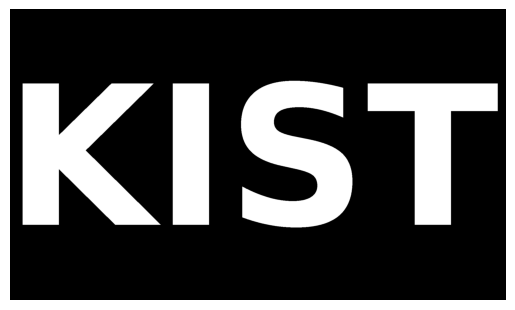

In [20]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

# 이미지 크기 설정
width, height = 2048, 1200

# 흰 배경의 1비트 이미지 생성
img = Image.new('1', (width, height), color=0)

# 글꼴 설정
font_size = 800
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
except:
    font = ImageFont.load_default()

# 드로잉 객체 생성
draw = ImageDraw.Draw(img)

# 글자 크기 계산 (textbbox 사용)
text = "KIST"
bbox = draw.textbbox((0, 0), text, font=font)
text_width = bbox[2] - bbox[0]
text_height = bbox[3] - bbox[1]

# 중앙 정렬 좌표 계산
x = (width - text_width - 50) // 2
y = (height - text_height-300) // 2

# 글자 쓰기 (하얀색=1)
draw.text((x, y), text, fill=1, font=font)

# 결과 저장
img.save("/home/jhchang/dlpyc900/Test_image/kist_image.bmp")

# numpy 배열로 변환 (필요하면)
img_array = np.array(img, dtype=np.uint8)

print("완료: kist_image.bmp 생성, 배열 shape:", img_array.shape)
plt.imshow(img)
plt.axis('off')

In [43]:
def rle_encode_dlp(img: np.ndarray) -> bytes:
    """
    TI Special RLE 압축 (repeat/copy/raw)
    """
    height, width, _ = img.shape
    output = bytearray()
    prev_line = None

    for y in range(height):
        line = img[y]
        x = 0
        raw = 0

        while x < width:
            repeat = 1
            while x + repeat < width and np.array_equal(line[x], line[x + repeat]):
                repeat += 1

            copy = 0
            if prev_line is not None:
                while x + copy < width and np.array_equal(line[x + copy], prev_line[x + copy]):
                    copy += 1

            if copy >= repeat and copy > 0:
                if raw > 0:
                    output.append(0x00)
                    output.append(raw)
                    for i in range(raw):
                        output.extend(bytes(line[x - raw + i][::-1]))
                    raw = 0

                output.append(0x00)
                output.append(0x01)
                if copy < 128:
                    output.append(copy)
                else:
                    output.append((copy & 0x7F) | 0x80)
                    output.append(copy >> 7)
                x += copy

            elif repeat > 1:
                if raw > 0:
                    output.append(0x00)
                    output.append(raw)
                    for i in range(raw):
                        output.extend(bytes(line[x - raw + i][::-1]))
                    raw = 0

                if repeat < 128:
                    output.append(repeat)
                else:
                    output.append((repeat & 0x7F) | 0x80)
                    output.append(repeat >> 7)
                output.extend(bytes(line[x][::-1]))
                x += repeat

            else:
                raw += 1
                x += 1

                if raw == 128:
                    output.append(0x00)
                    output.append(127)
                    for i in range(127):
                        output.extend(bytes(line[x - raw + i][::-1]))
                    raw = 1  # 지금 픽셀 다시 시작

        if raw > 0:
            output.append(0x00)
            output.append(raw)
            for i in range(raw):
                output.extend(bytes(line[x - raw + i][::-1]))

        prev_line = line

    output.append(0x00)
    output.append(0x01)
    output.append(0x00)

    return bytes(output)

In [ ]:
def rle_decode_dlp(data: bytes, width: int, height: int) -> np.ndarray:
    decoded = np.zeros((height, width, 3), dtype=np.uint8)
    prev_line = np.zeros((width, 3), dtype=np.uint8)
    idx = 0
    x = 0
    y = 0

    while idx < len(data):
        cmd = data[idx]
        idx += 1

        if cmd == 0:
            subcmd = data[idx]
            idx += 1

            if subcmd == 0:  # end of line
                y += 1
                if y >= height:
                    break
                prev_line = decoded[y - 1].copy()
                x = 0

            elif subcmd == 1:  # copy from previous line
                if idx >= len(data):
                    break
                nextbyte = data[idx]
                idx += 1

                if nextbyte == 0:  # end of image
                    break
                else:
                    copy_count = nextbyte
                    if copy_count & 0x80:
                        copy_count = (copy_count & 0x7F) | (data[idx] << 7)
                        idx += 1

                for _ in range(copy_count):
                    if x >= width:
                        break

                    decoded[y, x, :] = prev_line[x, :]
                    x += 1

            else:  # raw pixels
                raw_count = subcmd
                if raw_count & 0x80:
                    raw_count = (raw_count & 0x7F) | (data[idx] << 7)
                    idx += 1

                for _ in range(raw_count):
                    if idx + 3 > len(data):
                        break
                    b, g, r = data[idx:idx+3]
                    decoded[y, x] = [r, g, b]
                    x += 1
                    if x >= width:
                        x = 0
                        y += 1
                        if y >= height:
                            break
                    idx += 3

        else:  # repeated pixel
            repeat_count = cmd
            if repeat_count & 0x80:
                repeat_count = (repeat_count & 0x7F) | (data[idx] << 7)
                idx += 1

            if idx + 3 > len(data):
                break
            b, g, r = data[idx:idx+3]
            idx += 3
            for _ in range(repeat_count):
                if x >= width:
                    x = 0
                    y += 1
                    if y >= height:
                        break
                decoded[y, x] = [r, g, b]
                x += 1

    return decoded


In [59]:
mid_x = img_array.shape[1] // 2
left_half = img_array[:, :mid_x]
right_half = img_array[:, mid_x:]

img = rgb24(right_half)
encoded = rle_encode_dlp(img)
print(f"압축 전: {img.nbytes} bytes")
print(f"압축 후: {len(encoded)} bytes")

height , width, _ = np.shape(img)
decoded = rle_decode_dlp(encoded, width, height)
print("복원 성공 여부:", np.array_equal(img, decoded))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(decoded)
axs[1].set_title("Decoded Image")
axs[1].axis('off')

압축 전: 3686400 bytes
압축 후: 8027 bytes


IndexError: index 1200 is out of bounds for axis 0 with size 1200

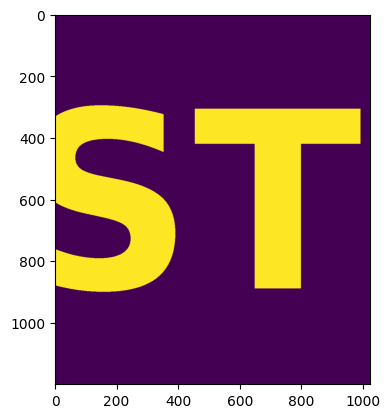

In [35]:
plt.imshow(right_half)

In [ ]:
import numpy as np
import os, sys 
from PIL import Image
from pathlib import Path

# 상대경로 추가
sys.path.append(str(Path("..").resolve() / "Test_image"))

image_folder = "Test_image"
# filename = "0000.bmp"
# filename = "kist_image.bmp"
filename = "2048x1200_output.bmp"
image_path = os.path.join(image_folder, filename)
img = Image.open(image_path).convert("1")
img_array = np.array(img, dtype= np.uint8)


mid_x = img_array.shape[1] // 2
left_half = img_array[:, :mid_x]
left_half = np.flipud(left_half)

right_half = img_array[:, mid_x:]
right_half = np.flipud(right_half)

FileNotFoundError: [Errno 2] No such file or directory: 'Test_image\\2048x1200_output.bmp'

In [20]:
from pathlib import Path

# 방법 1: 역슬래시 주의하여 이스케이프
# image_folder = Path(r"C:\Users\wlsgu\JH\Project\KIST\code\control_dlp\dlpyc900\Test_image")

# 방법 2: 슬래시 사용
image_folder = Path("C:/Users/wlsgu/JH/Project/KIST/code/control_dlp/dlpyc900/Test_image")

filename = "2048x1200_output.bmp"
image_path = image_folder / filename

# 존재 확인
if not image_path.exists():
    raise FileNotFoundError(f"{image_path} 파일이 존재하지 않습니다.")

# 이미지 열기
from PIL import Image
import numpy as np

img = Image.open(image_path).convert("1")
img_array = np.array(img) // 255


In [21]:
os.getcwd()

'c:\\Users\\wlsgu\\JH\\Project\\KIST\\code\\control_dlp\\dlpyc900\\Test_connection'